# Setup Enviroment

In [17]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torchvision.transforms import v2
from torch import nn

from torchvision.io import read_image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

import lightgbm as lgb
import xgboost as xgb

from catboost import Pool, CatBoostRegressor


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  print('GPU is not detected. Make sure you have chosen the right runtime type')


Everything looks good; continue


# load data 

In [18]:
df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

img_path_df = df['id'].apply(lambda x: os.path.join('./data/train_images', f'{x}.jpeg'))
img_path_test_df = test_df['id'].apply(lambda x: os.path.join('./data/test_images', f'{x}.jpeg'))


df.insert(1, 'img_path', img_path_df)
test_df.insert(1, 'img_path', img_path_test_df)

# Config

In [19]:
class CFG():
  # X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
  TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
  PRED_COLUMNS = ['X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
  # remove target columns and id
  FEATURE_COLUMNS = df.columns.drop(['id', 'X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean', 'img_path']).to_list()

  BATCH_SIZE = 64
  NUM_EPOCHS = 6

  NUM_TARGETS = 6
  NUM_FEATURES = 163

  LEARNING_RATE = 0.001
  WEIGHT_DECAY = 0.0001

  SEED = 42

print(CFG.TARGET_COLUMNS)
print(CFG.PRED_COLUMNS)
print(CFG.FEATURE_COLUMNS)


['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
['X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_5.15cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg', 'SOIL_cec_100.200cm_mean_0.01_deg', 'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg', 'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg', 'SOIL_cfvo_0.5cm_mean_0.01_deg', 'SOIL_cfvo_100.200cm_mean_0.01_deg', 'SOIL_cfvo_15.30cm_mean_0.01_deg', 'SOIL_cfvo_30.60cm_mean_0.01_deg', 'SOIL_cfvo_5.15cm_mean_0.01_deg', 'SOIL_cf

# Preprocess

## remove outliers

(43363, 171)
(38148, 171)


array([[<Axes: title={'center': 'X4_mean'}>,
        <Axes: title={'center': 'X11_mean'}>],
       [<Axes: title={'center': 'X18_mean'}>,
        <Axes: title={'center': 'X26_mean'}>],
       [<Axes: title={'center': 'X50_mean'}>,
        <Axes: title={'center': 'X3112_mean'}>]], dtype=object)

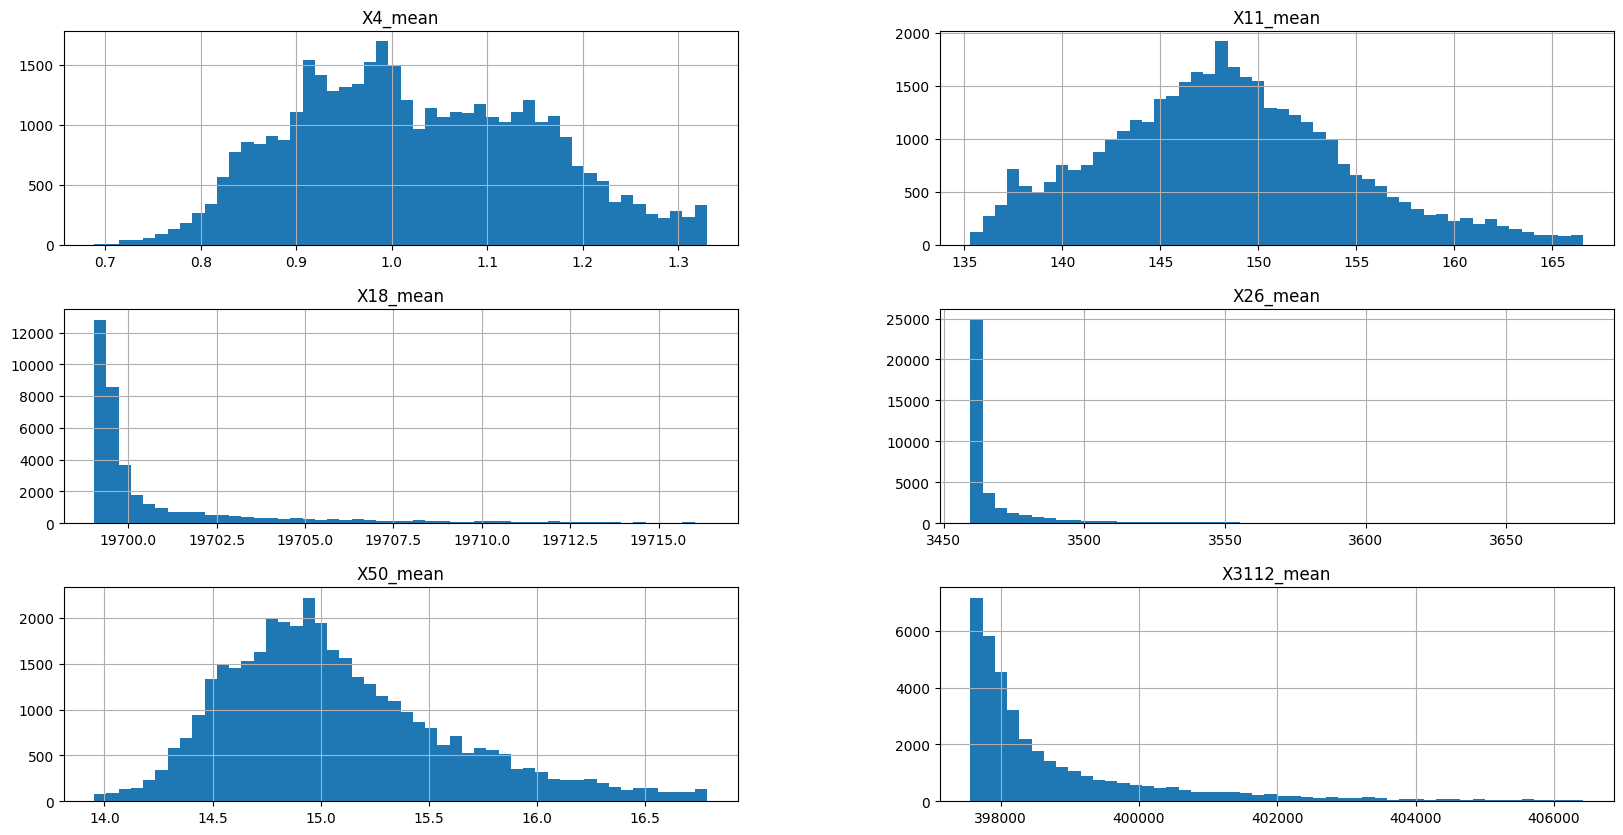

In [20]:
# remove 98% upper_quantile and 0.1% lower_quantile
print(df.shape)
for col in CFG.TARGET_COLUMNS:
  upper_quantile = df[col].quantile(0.98)
  lower_quantile = df[col].quantile(0.001)
  df = df[df[col] < upper_quantile ]
  df = df[df[col] > lower_quantile ]
print(df.shape)
df[CFG.TARGET_COLUMNS].hist(bins=50, figsize=(20, 10))


## split data

In [21]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG.SEED)
print(train_df.shape, val_df.shape)


(30518, 171) (7630, 171)


# Get image embedding

In [10]:
def get_embeddings(model, df, transform):
  model.eval()
  embeddings = []
  with torch.no_grad():
    for i in tqdm(range(0,len(df), CFG.BATCH_SIZE)):
      img_paths = df['img_path'][i: i+CFG.BATCH_SIZE].values
      images = torch.stack([transform(read_image(img_path)) for img_path in img_paths])
      embedding = model(images.to(device))
      embeddings.append(embedding.cpu())
  return torch.cat(embeddings)


train_transform =v2.Compose([
  v2.Resize(140),
  v2.ToImage(), 
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
  v2.Resize(140),
  v2.ToImage(), 
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = v2.Compose([
  v2.Resize(140),
  v2.ToImage(), 
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg').to(device)

train_embeddings = get_embeddings(model, train_df, train_transform)
val_embeddings = get_embeddings(model, val_df,  val_transform)
test_embeddings = get_embeddings(model, test_df, test_transform)

print("Train embeddings: ",train_embeddings.shape)
print("Val embeddings: ",val_embeddings.shape)
print("Test embeddings: ",test_embeddings.shape)

Using cache found in /home/jedcheng/.cache/torch/hub/facebookresearch_dinov2_main
/home/jedcheng/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jedcheng/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jedcheng/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
100%|██████████| 100/100 [00:18<00:00,  5.34it/s]

Train embeddings:  torch.Size([30518, 768])
Val embeddings:  torch.Size([7630, 768])
Test embeddings:  torch.Size([6391, 768])


# Get final features

In [11]:
def cat_embedding(df, embeddings):
  return pd.concat([df, pd.DataFrame(embeddings)], axis=1)

# reset index
df = df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_final_df= cat_embedding(df, train_embeddings)
val_final_df = cat_embedding(val_df, val_embeddings)
test_final_df = cat_embedding(test_df, test_embeddings)

print("Train final: ", train_final_df.shape)
print("Val final: ", val_final_df.shape)
print("Test final: ", test_final_df.shape)

Train final:  (38148, 939)
Val final:  (7630, 939)
Test final:  (6391, 933)


In [94]:
# save the final data
train_final_df.to_csv('./data/train_final.csv', index=False)  
val_final_df.to_csv('./data/val_final.csv', index=False)
test_final_df.to_csv('./data/test_final.csv', index=False)

# LightGBM

In [15]:
# # load the final data
# train_final_df = pd.read_csv('./data/train_final.csv')
# val_final_df = pd.read_csv('./data/val_final.csv')
# test_final_df = pd.read_csv('./data/test_final.csv')

X_train = train_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_train = train_final_df[CFG.TARGET_COLUMNS]
X_val = val_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_val = val_final_df[CFG.TARGET_COLUMNS]
params = {
    'learning_rate': 0.005,
    # "max_depth": 8,
    # "max_bin": 2048,
    "num_iterations": 10000,
    # "num_leaves": 100,
    # "early_stopping_round": 100,
    "bagging_freq": 7,
    "bagging_fraction": 0.75,
    "feature_fraction": 0.75,
    'lambda_l1': 0.01,  # Reduce regularization
    'lambda_l2': 0.01,
}

print("X_train.values: ", X_train.values.shape)

lgbm_model = lgb.LGBMRegressor(**params)
sklearn_model = MultiOutputRegressor(lgbm_model)
sklearn_model.fit(
  X = X_train,
  y = y_train,
)


score = sklearn_model.score(X_val, y_val)
print("Score: ", score)


X_train.values:  (38148, 931)


/home/jedcheng/.pyenv/versions/cs680/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: ba

KeyboardInterrupt: 

# XGboost

In [19]:

X_train = train_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_train = train_final_df[CFG.TARGET_COLUMNS]
X_val = val_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_val = val_final_df[CFG.TARGET_COLUMNS]

xgb_model = xgb.XGBRegressor(
    tree_method="hist",
    learning_rate=0.005,
    random_state=CFG.SEED,
    multi_strategy='multi_output_tree',
    eval_metric=sklearn.metrics.mean_squared_error,
    n_estimators=1000,
)



sklearn_model = MultiOutputRegressor(xgb_model)
sklearn_model.fit(
  X = X_train,
  y = y_train,
)
     


score = sklearn_model.score(X_val, y_val)
print("Score: ", score)

Score:  0.49601277709007263


# Catboost

In [27]:
# catboost
X_train = train_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_train = train_final_df[CFG.TARGET_COLUMNS]
X_val = val_final_df.drop(['id', 'img_path']+CFG.TARGET_COLUMNS, axis=1)
y_val = val_final_df[CFG.TARGET_COLUMNS]

params = {'learning_rate': 0.05, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'GPU', 
          'iterations': 10000,
          'boosting_type': 'Plain', 
         }

cat_model = CatBoostRegressor(**params) 

cat_model.fit(
  X = X_train,
  y = y_train,
  eval_set=(X_val, y_val),
)

score = cat_model.score(X_val, y_val)
print("Score: ", score)


0:	learn: 1547.8949439	test: 1563.1757600	best: 1563.1757600 (0)	total: 18.1ms	remaining: 3m
1:	learn: 1531.4187035	test: 1546.3240632	best: 1546.3240632 (1)	total: 35.1ms	remaining: 2m 55s
2:	learn: 1516.4007695	test: 1530.9593131	best: 1530.9593131 (2)	total: 52.2ms	remaining: 2m 53s
3:	learn: 1502.3360739	test: 1516.4464442	best: 1516.4464442 (3)	total: 69.3ms	remaining: 2m 53s
4:	learn: 1489.3459251	test: 1503.6321348	best: 1503.6321348 (4)	total: 87.9ms	remaining: 2m 55s
5:	learn: 1477.6504377	test: 1491.8331552	best: 1491.8331552 (5)	total: 106ms	remaining: 2m 56s
6:	learn: 1466.4764272	test: 1480.6527157	best: 1480.6527157 (6)	total: 124ms	remaining: 2m 56s
7:	learn: 1456.3006878	test: 1470.1028746	best: 1470.1028746 (7)	total: 141ms	remaining: 2m 55s
8:	learn: 1446.3643497	test: 1460.2812117	best: 1460.2812117 (8)	total: 159ms	remaining: 2m 56s
9:	learn: 1437.1697373	test: 1450.8681586	best: 1450.8681586 (9)	total: 177ms	remaining: 2m 57s
10:	learn: 1429.0009395	test: 1442.8787

# Test loop

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: ba

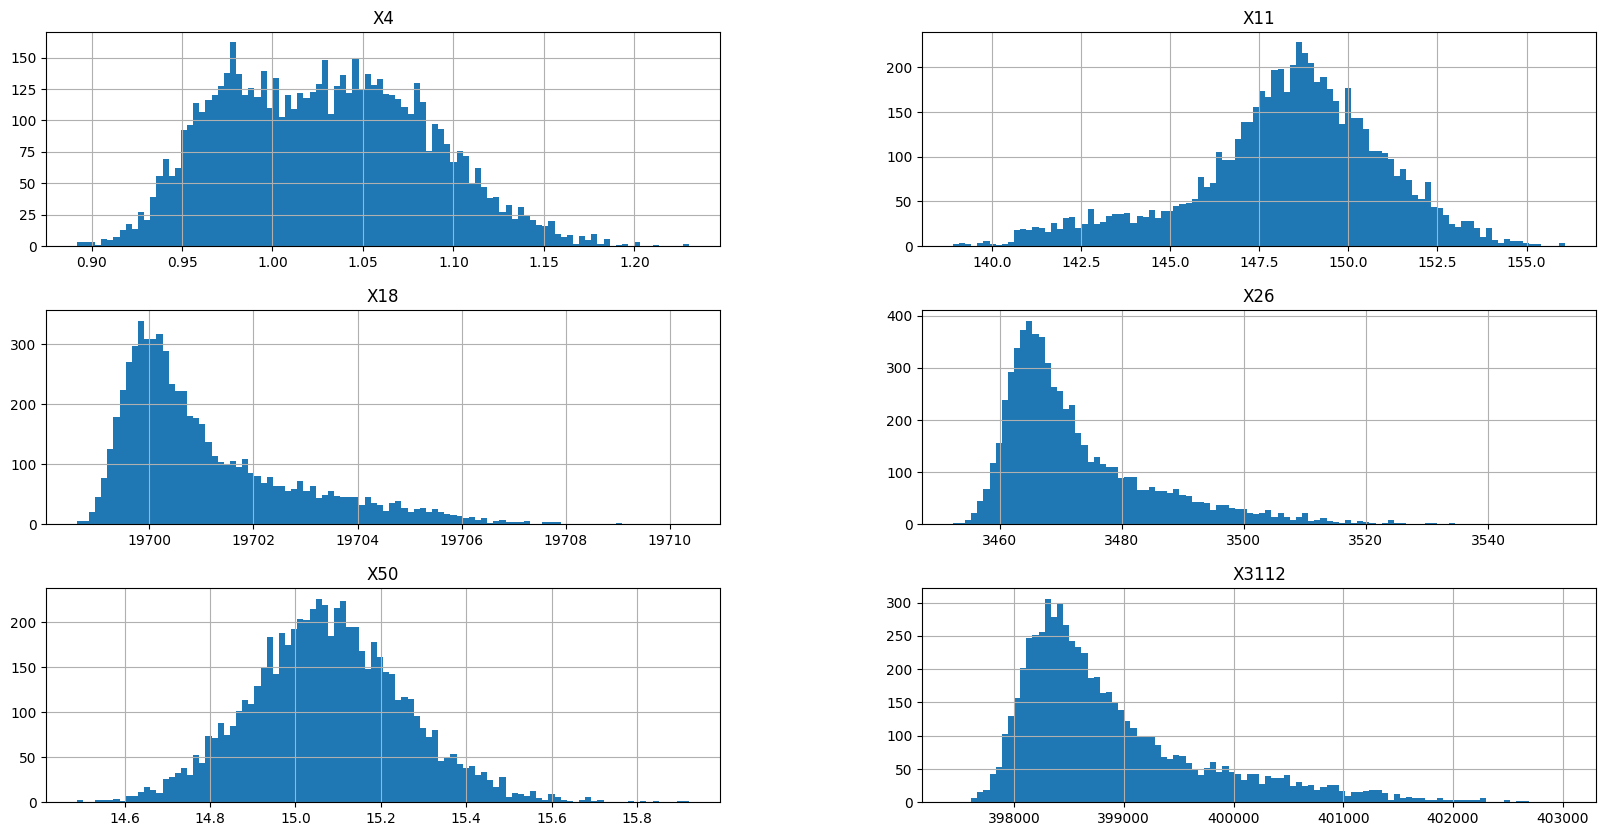

In [14]:
# Load model

X_test = test_final_df.drop(['id', 'img_path'], axis=1)

y_test = sklearn_model.predict(X_test)
# y_test = cat_model.predict(X_test)

#concatenate test_df[ids] to the predictions
ids = test_df.iloc[:,0].values
y_test = np.concatenate((ids.reshape(-1,1), y_test), axis=1)

preds_df = pd.DataFrame(
  y_test,
  columns=["id"] + CFG.PRED_COLUMNS
)
preds_df["id"] = preds_df["id"].astype(int)


# denormalize the predictions
# preds_df[CFG.TARGET_COLUMNS] = target_scaler.inverse_transform(preds_df[CFG.TARGET_COLUMNS])
# preds_df[CFG.PRED_COLUMNS] = np.expm1(preds_df[CFG.PRED_COLUMNS])
  
preds_df[CFG.PRED_COLUMNS].hist(bins=100, figsize=(20, 10))

preds_df.to_csv('submission.csv', index=False)

In [ ]:
# compare the predictions with the actu